In [15]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [16]:
from helper import *
from copy import deepcopy

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cpu


In [21]:
# Iris Network
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)


    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
from torchsummary import summary

model1 = IrisNet()
summary(model1, input_size=(4,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 3]             195
Total params: 9,091
Trainable params: 9,091
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [5]:
# Iris Dataset
iris = sklearn_datasets.load_iris()
X_iris = torch.FloatTensor(iris.data)
y_iris = torch.LongTensor(iris.target)

# Shuffle the dataset before splitting (deterministic with seed)
np.random.seed(42)
indices = np.random.permutation(len(X_iris))
X_iris_shuffled = X_iris[indices]
y_iris_shuffled = y_iris[indices]

# Split into train/test
split = int(0.90 * len(X_iris_shuffled))
X_iris_train, X_iris_test = X_iris_shuffled[:split], X_iris_shuffled[split:]
y_iris_train, y_iris_test = y_iris_shuffled[:split], y_iris_shuffled[split:]

iris_train_loader = DataLoader(TensorDataset(X_iris_train, y_iris_train), batch_size=32, shuffle=False)
iris_test_loader = DataLoader(TensorDataset(X_iris_test, y_iris_test), batch_size=32, shuffle=False)

All seeds set to: 0
Model weights initialized with seed: 0
All seeds set to: 1
Model weights initialized with seed: 1
All seeds set to: 2
Model weights initialized with seed: 2
All seeds set to: 3
Model weights initialized with seed: 3
All seeds set to: 4
Model weights initialized with seed: 4


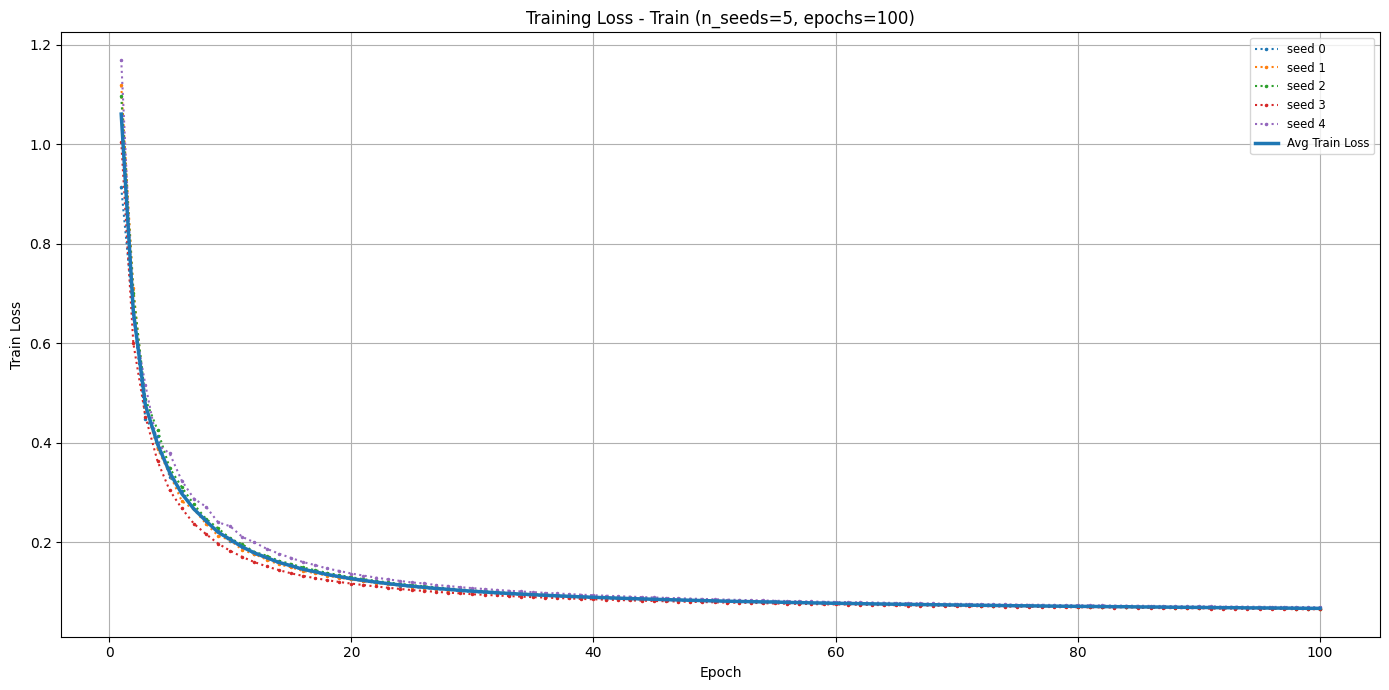

In [6]:
results_train = train_multiple_inits_and_plot(
    network_fn=lambda: IrisNet(),
    train_loader=iris_train_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer_fn=lambda m: optim.Adam(m.parameters(), lr=0.001),
    seeds=[0,1,2,3,4],
    num_epochs=100,                    # short for smoke test
    figsize=(14,7),
    plot_val=True,
    alpha=1
)

All seeds set to: 0
Model weights initialized with seed: 0
All seeds set to: 1
Model weights initialized with seed: 1
All seeds set to: 2
Model weights initialized with seed: 2
All seeds set to: 3
Model weights initialized with seed: 3
All seeds set to: 4
Model weights initialized with seed: 4


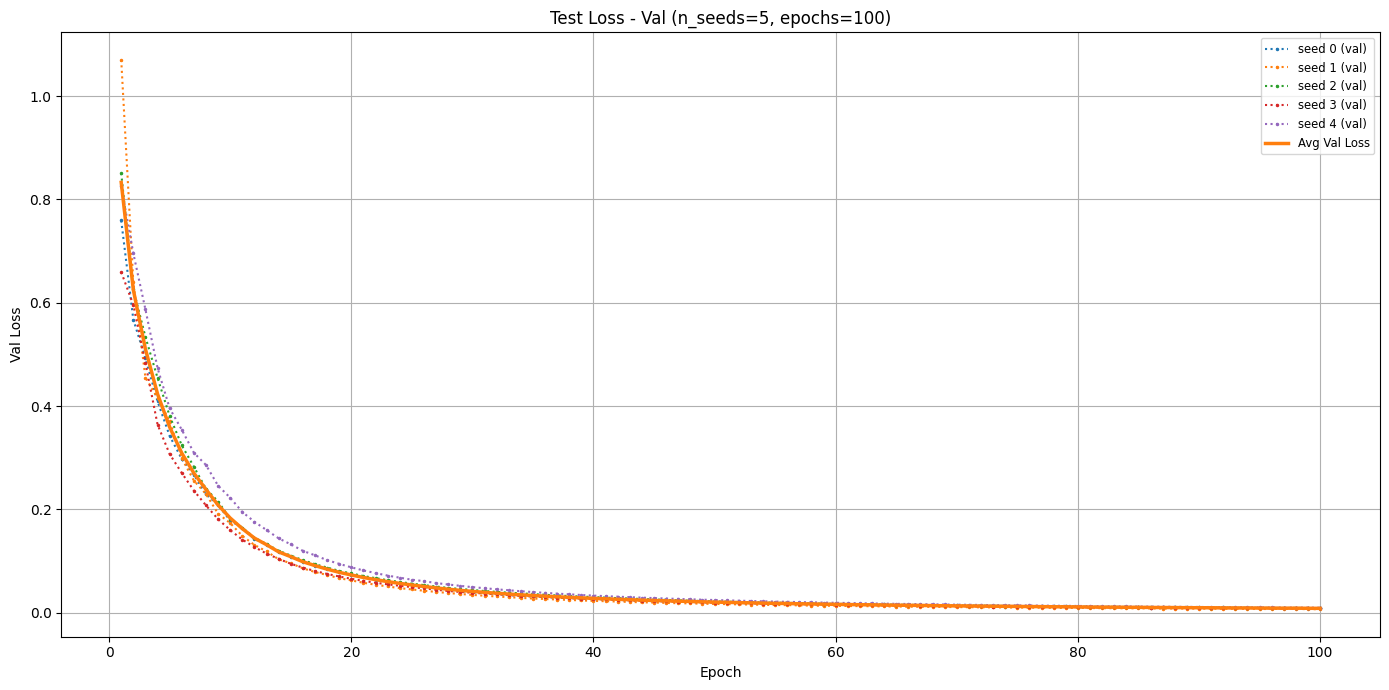

In [7]:
results_test = train_multiple_inits_and_plot(
    network_fn=lambda: IrisNet(),
    train_loader=iris_train_loader,
    criterion=nn.CrossEntropyLoss(),
    optimizer_fn=lambda m: optim.Adam(m.parameters(), lr=0.001),
    seeds=[0,1,2,3,4],
    num_epochs=100,
    figsize=(14,7),
    test_loader=iris_test_loader,   # required for val runs
    plot_val=True,                  # allow val runs to be recorded/used
    loss_view="val",                # show only validation (test) loss
    alpha=1,
    title_prefix="Test Loss"
)

In [14]:
import numpy as np

# Convert to numpy array, shape will be (num_seeds, num_steps)
train_runs = np.array(results_test['train_runs'])

# Mean and std across seeds (axis=0 = across rows, per training step)
mean_loss = np.mean(train_runs, axis=0)
std_loss  = np.std(train_runs, axis=0)

print("Shape of train_runs:", train_runs.shape)  # e.g. (6, 100)
print("Mean shape:", mean_loss.shape)           # (100,)
print("Std shape:", std_loss)             # (100,)

Shape of train_runs: (5, 100)
Mean shape: (100,)
Std shape: [0.09076866 0.03980609 0.02460136 0.02145389 0.02410955 0.0199133
 0.01670991 0.01768927 0.01438269 0.01578265 0.01321828 0.01268101
 0.01151946 0.01077972 0.01005299 0.00912896 0.0085321  0.00767124
 0.00724118 0.00660796 0.00622692 0.00582645 0.00551173 0.0052711
 0.00496572 0.00493863 0.0044977  0.00436455 0.00410315 0.00401442
 0.00379826 0.00363028 0.00352194 0.00334289 0.00327299 0.00309282
 0.00299536 0.00283285 0.00276652 0.00266503 0.00256827 0.00245725
 0.00242776 0.00230433 0.00225944 0.00218044 0.002149   0.00206471
 0.00201759 0.00194526 0.00195163 0.00183493 0.00173648 0.00173014
 0.00181464 0.00172291 0.00169183 0.0016623  0.00165195 0.00163612
 0.00151535 0.00156121 0.00155808 0.0015373  0.00145123 0.00156411
 0.00143448 0.00150825 0.00139358 0.00142896 0.00144736 0.00139401
 0.001352   0.00147159 0.00138728 0.00137245 0.00139124 0.00138671
 0.00137695 0.00134953 0.00135917 0.00129326 0.00131814 0.00104632
 0.0

In [12]:
len(results_test['train_runs'][0])

100